#**Đề tài: Phân tích, thống kê video thịnh hành trên youtube theo các quốc gia**


# 1. Gather data

## 1.1 Problem Statement
## **Trần Phan Minh Tiến**

    Question 1: Vẽ biểu đồ tròn thể hiện tỷ lệ số lượng video thịnh hành tại 10 quốc gia:
    Hoa Kỳ (US), Canada (CA), Đức (DE), Pháp (FR), Anh (GB), Ấn Độ (IN), Nhật Bản (JP), Hàn Quốc (KR), Mexico (MX), Nga (RU).

    Question 2: Vẽ biểu đồ cột so sánh lượt thích, không thích, lượt xem và bình luận trung bình của các video thịnh hành.
##**Trần Minh Thuận**

    Question 3: dang suy nghi

    Question 4: Biểu đồ thể hiện thể loại nội dung trending cho từng quốc gia
##**Hoàng Văn Đức**

    Question 5:  Vẽ biểu đồ cột nhóm thể hiện số lượng video thịnh hành theo quý trong các năm 2015, 2020 và 2024.

    Question 6: Vẽ biểu đồ đường hoặc cột thể hiện lượt xem trung bình theo từng ngày trong tuần của video thịnh hành năm 2024.

## 1.2 Import libraries:

In [7]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
from collections import Counter
import kagglehub
import datetime
import wordcloud
import json


# TẢI DATA XUỐNG TỪ KAGGLEHUB

In [8]:
# Download latest version
kaggle_download_path = kagglehub.dataset_download("datasnaek/youtube-new")
print("Path to dataset files:", kaggle_download_path)

Path to dataset files: /home/thuanc177/.cache/kagglehub/datasets/datasnaek/youtube-new/versions/115


In [9]:
# Hiding warnings for cleaner display
warnings.filterwarnings('ignore')

# Configuring some options
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# If you want interactive plots, uncomment the next line
# %matplotlib notebook

#Gán Mã màu, thuộc tính cho đồ thị

In [10]:
PLOT_COLORS = ["#268bd2", "#0052CC", "#FF5722", "#b58900", "#003f5c"]
pd.options.display.float_format = '{:.2f}'.format
sns.set(style="ticks")
plt.rc('figure', figsize=(8, 5), dpi=100)
plt.rc('axes', labelpad=20, facecolor="#ffffff", linewidth=0.4, grid=True, labelsize=14)
plt.rc('patch', linewidth=0)
plt.rc('xtick.major', width=0.2)
plt.rc('ytick.major', width=0.2)
plt.rc('grid', color='#9E9E9E', linewidth=0.4)
plt.rc('font', family='DejaVu Sans', weight='400', size=10)
plt.rc('text', color='#282828')
plt.rc('savefig', pad_inches=0.3, dpi=300)

#Đọc tất cả các file

In [11]:
def read_and_fix_csv(path, fix_columns=None, default_encoding='utf-8', fallback_encoding='ISO-8859-1'):
    """
    Đọc CSV với kiểm tra encoding, và sửa lỗi encoding ở một số cột nếu cần.
    """
    try:
        df = pd.read_csv(path, encoding=default_encoding)
    except UnicodeDecodeError:
        df = pd.read_csv(path, encoding=fallback_encoding)

    if fix_columns:
        for col in fix_columns:
            if col in df.columns:
                df[col] = df[col].apply(fix_encoding)

    return df

def fix_encoding(s):
    try:
        return s.encode('latin1').decode('utf-8')
    except:
        return s  # giữ nguyên nếu không chuyển được


In [12]:
# Danh sách quốc gia và các đường dẫn tương ứng
country_codes = ['US', 'CA', 'DE', 'FR', 'GB', 'IN', 'JP', 'KR', 'MX', 'RU']
columns_to_fix = ['title', 'channel_title', 'description', 'tags']

# Tạo dict lưu các DataFrame
dataframes = {}

for code in country_codes:
    filepath = f"{kaggle_download_path}/{code}videos.csv"
    fix = code in ['JP', 'KR', 'RU']  # JP, KR, RU cần sửa lỗi encoding
    df = read_and_fix_csv(filepath, fix_columns=columns_to_fix if fix else None)
    dataframes[code] = df

## 1.3 Xem thông tin của Dataset

#VIẾT HÀM HIỂN THỊ THÔNG TIN CƠ BẢN CHO TỪNG DỮ LIỆU CỦA TỪNG QUỐC GIA

In [13]:
def display_basic_info(dataframes, country_names):
    """
    Hiển thị thông tin tổng quan và chi tiết về dữ liệu từng quốc gia.
    """
    print("\n=== 📊 THÔNG TIN CƠ BẢN VỀ DỮ LIỆU ===")

    total_records = 0
    for country, df in dataframes.items():
        print(f"\n{country_names.get(country, 'Unknown')} ({country}):")
        print(f"  - 📄 Số bản ghi: {len(df):,}")
        print(f"  - 🧱 Số cột: {len(df.columns)}")
        print(f"  - 💾 Kích thước bộ nhớ: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

        # Video duy nhất
        unique_videos = df['video_id'].nunique() if 'video_id' in df.columns else 'N/A'
        print(f"  - 🎥 Video duy nhất: {unique_videos:,}")

        # Category phổ biến
        if 'category_id' in df.columns:
            top_categories = df['category_id'].value_counts().head(3).to_dict()
            print(f"  - 🔢 Top 3 category_id: {top_categories}")

        # Mô tả bị thiếu (NaN hoặc rỗng)
        missing_descriptions = df['description'].isna().sum() if 'description' in df.columns else 0
        empty_descriptions = (df['description'] == '').sum() if 'description' in df.columns else 0
        total_missing = missing_descriptions + empty_descriptions
        if 'description' in df.columns:
            missing_rate = total_missing / len(df) * 100
            print(f"  - 📝 Mô tả thiếu (NaN + rỗng): {total_missing:,} ({missing_rate:.2f}%)")

        # Ngày xuất bản sớm nhất & muộn nhất
        if 'publish_time' in df.columns:
            try:
                df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce')
                min_date = df['publish_time'].min()
                max_date = df['publish_time'].max()
                print(f"  - 📆 Ngày đăng: {min_date.date()} ➝ {max_date.date()}")
            except Exception as e:
                print(f"  - ⚠️ Lỗi chuyển đổi ngày: {e}")

        # Cột có dữ liệu thiếu
        null_columns = df.columns[df.isnull().any()]
        if len(null_columns):
            print(f"  - ⚠️ Các cột có missing values: {', '.join(null_columns)}")

        total_records += len(df)

    print(f"\n📈 TỔNG KẾT:")
    print(f"  - Tổng số bản ghi: {total_records:,}")
    print(f"  - Số quốc gia: {len(dataframes)}")


#GÁN NHÃN TÊN CHO CÁC MÃ QUỐC GIA

In [14]:
country_names = {
    'US': 'United States',
    'CA': 'Canada',
    'DE': 'Germany',
    'FR': 'France',
    'GB': 'United Kingdom',
    'IN': 'India',
    'JP': 'Japan',
    'KR': 'South Korea',
    'MX': 'Mexico',
    'RU': 'Russia'
}


#GỌI HÀM HIỂN THỊ THÔNG TIN DỮ LIỆU

In [15]:
display_basic_info(dataframes, country_names)


=== 📊 THÔNG TIN CƠ BẢN VỀ DỮ LIỆU ===

United States (US):
  - 📄 Số bản ghi: 40,949
  - 🧱 Số cột: 16
  - 💾 Kích thước bộ nhớ: 109.6 MB
  - 🎥 Video duy nhất: 6,351
  - 🔢 Top 3 category_id: {24: 9964, 10: 6472, 26: 4146}
  - 📝 Mô tả thiếu (NaN + rỗng): 570 (1.39%)
  - 📆 Ngày đăng: 2006-07-23 ➝ 2018-06-14
  - ⚠️ Các cột có missing values: description

Canada (CA):
  - 📄 Số bản ghi: 40,881
  - 🧱 Số cột: 16
  - 💾 Kích thước bộ nhớ: 109.8 MB
  - 🎥 Video duy nhất: 24,427
  - 🔢 Top 3 category_id: {24: 13451, 25: 4159, 22: 4105}
  - 📝 Mô tả thiếu (NaN + rỗng): 1,296 (3.17%)
  - 📆 Ngày đăng: 2008-01-13 ➝ 2018-06-14
  - ⚠️ Các cột có missing values: description

Germany (DE):
  - 📄 Số bản ghi: 40,840
  - 🧱 Số cột: 16
  - 💾 Kích thước bộ nhớ: 114.2 MB
  - 🎥 Video duy nhất: 29,627
  - 🔢 Top 3 category_id: {24: 15292, 22: 5988, 25: 2935}
  - 📝 Mô tả thiếu (NaN + rỗng): 1,552 (3.80%)
  - 📆 Ngày đăng: 2012-04-18 ➝ 2018-06-14
  - ⚠️ Các cột có missing values: description

France (FR):
  - 📄 Số bản ghi

# 2. Truy cập vào dữ liệu:

---



In [16]:
def basic_data_access(dataframes, country_names):
    print("\n" + "=" * 60)
    print("=== TRUY CẬP VÀ KHÁM PHÁ DỮ LIỆU CƠ BẢN ===")
    print("=" * 60)

    for country, df in dataframes.items():
        print(f"\n🌍 {country_names[country]} ({country})")
        print("-" * 50)

        print(f"📊 Tổng quan: {len(df):,} hàng | {len(df.columns)} cột | {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

        print("\n📋 Cấu trúc dữ liệu:")
        for col in df.columns:
            print(f"   • {col:<20} | {str(df[col].dtype):<10} | Null: {df[col].isna().sum():,}")

        # 3. Mẫu dữ liệu
        print("\n👀 Mẫu dữ liệu (5 dòng):")
        try:
            display_cols = ['title', 'channel_title', 'views', 'likes', 'trending_date']
            print(df[display_cols].head().to_string(index=False, max_colwidth=30))
        except:
            print("   ⚠ Không thể hiển thị mẫu")

        # 4. Thống kê mô tả
        print("\n📈 Thống kê mô tả:")
        num_cols = ['views', 'likes', 'dislikes', 'comment_count']
        num_cols = [col for col in num_cols if col in df.columns]
        if num_cols:
            print(df[num_cols].describe().round(1).to_string())
        else:
            print("   ⚠ Không có cột số")

        # 5. Missing values
        print("\n❓ Missing values:")
        missing = df.isna().sum()
        missing = missing[missing > 0]
        if not missing.empty:
            for col, val in missing.items():
                print(f"   • {col}: {val:,} ({val / len(df) * 100:.1f}%)")
        else:
            print("   ✓ Không có missing values")

        # 6. Top categories
        print("\n🏆 Top 5 categories:")
        if 'category_id' in df.columns:
            print(df['category_id'].value_counts().head().to_string())
        else:
            print("   ⚠ Không có cột category_id")

        # 7. Top channels
        print("\n🎬 Top 5 channels:")
        if 'channel_title' in df.columns:
            print(df['channel_title'].value_counts().head().to_string())
        else:
            print("   ⚠ Không có cột channel_title")

        # 8. Phân tích thời gian
        print("\n📅 Phân tích thời gian:")
        if 'trending_date' in df.columns:
            try:
                dates = pd.to_datetime(df['trending_date'], errors='coerce')
                print(f"   • {dates.min().date()} → {dates.max().date()} ({(dates.max() - dates.min()).days} ngày)")
                print("   • Theo năm:")
                print(dates.dt.year.value_counts().sort_index().to_string())
            except:
                print("   ⚠ Không thể phân tích trending_date")
        else:
            print("   ⚠ Không có cột trending_date")

        # 9. Top performers
        print("\n🌟 Top performers:")
        for col in ['views', 'likes', 'comment_count']:
            if col in df.columns:
                idx = df[col].idxmax()
                title = df.at[idx, 'title'] if 'title' in df.columns else 'Không rõ'
                print(f"   • Max {col}: {df.at[idx, col]:,} - '{title[:40]}...'")

        # 10. Kiểm tra chất lượng
        print("\n🔍 Kiểm tra chất lượng:")
        issues = []
        for col in ['views', 'likes', 'dislikes']:
            if col in df.columns and (df[col] < 0).any():
                issues.append(f"{col} âm: {(df[col] < 0).sum()}")

        if 'title' in df.columns:
            empty_titles = df['title'].str.strip().eq('').sum()
            if empty_titles > 0:
                issues.append(f"Title rỗng: {empty_titles}")

        if 'video_id' in df.columns:
            dup = df.duplicated('video_id').sum()
            if dup > 0:
                issues.append(f"Trùng video_id: {dup}")

        if issues:
            for issue in issues:
                print(f"   ⚠ {issue}")
        else:
            print("   ✓ Không phát hiện vấn đề rõ ràng")

        print("=" * 50)


In [17]:
basic_data_access(dataframes, country_names)


=== TRUY CẬP VÀ KHÁM PHÁ DỮ LIỆU CƠ BẢN ===

🌍 United States (US)
--------------------------------------------------
📊 Tổng quan: 40,949 hàng | 16 cột | 107.03 MB

📋 Cấu trúc dữ liệu:
   • video_id             | object     | Null: 0
   • trending_date        | object     | Null: 0
   • title                | object     | Null: 0
   • channel_title        | object     | Null: 0
   • category_id          | int64      | Null: 0
   • publish_time         | datetime64[ns, UTC] | Null: 0
   • tags                 | object     | Null: 0
   • views                | int64      | Null: 0
   • likes                | int64      | Null: 0
   • dislikes             | int64      | Null: 0
   • comment_count        | int64      | Null: 0
   • thumbnail_link       | object     | Null: 0
   • comments_disabled    | bool       | Null: 0
   • ratings_disabled     | bool       | Null: 0
   • video_error_or_removed | bool       | Null: 0
   • description          | object     | Null: 570

👀 Mẫu dữ liệu (5 

## 2.1 Thêm cột

# Thêm các cột phân tích hiệu suất vào DataFrame.

In [18]:
def add_performance_metrics(df):
    """
    Thêm các cột phân tích hiệu suất vào DataFrame.

    Thêm các cột:
        - engagement_rate (%)
        - like_dislike_ratio
        - viral_score
        - performance_category

    Trả về: DataFrame mới với các cột bổ sung.
    """
    if df is None or df.empty:
        print("⚠️ DataFrame rỗng hoặc không hợp lệ.")
        return df

    print("🚀 Thêm cột phân tích hiệu suất...")

    df = df.copy()

    # Engagement Rate (%)
    df['engagement_rate'] = ((df['likes'] + df['comment_count']) / df['views'].replace(0, np.nan) * 100).round(2)
    df['engagement_rate'] = df['engagement_rate'].fillna(0).clip(lower=0)

    # Like/Dislike Ratio
    df['like_dislike_ratio'] = np.where(
        df['dislikes'] > 0,
        (df['likes'] / df['dislikes']).round(2),
        np.where(df['likes'] > 0, np.inf, 0)
    )

    # Viral Score
    max_views = df['views'].max() or 1
    max_engagement = df['engagement_rate'].max() or 1

    df['viral_score'] = (
        (df['views'] / max_views * 0.7 +
         df['engagement_rate'] / max_engagement * 0.3) * 100
    ).round(2)

    # Performance Category
    df['performance_category'] = pd.cut(
        df['viral_score'],
        bins=[0, 20, 40, 60, 80, 100],
        labels=['Low', 'Below Average', 'Average', 'Good', 'Excellent'],
        include_lowest=True
    )

    print("✅ Đã thêm: engagement_rate, like_dislike_ratio, viral_score, performance_category")
    return df

In [19]:
def add_time_analysis(df):
    """
    Thêm các cột phân tích thời gian vào DataFrame.
    """
    print("⏰ Thêm cột phân tích thời gian...")

    df = df.copy()
    df['trending_datetime'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m', errors='coerce')

    df['trending_weekday'] = df['trending_datetime'].dt.day_name()
    df['trending_month'] = df['trending_datetime'].dt.month_name()
    df['is_weekend_trending'] = df['trending_datetime'].dt.weekday >= 5
    df['trending_week'] = df['trending_datetime'].dt.isocalendar().week

    if 'publish_time' in df.columns:
        df['publish_datetime'] = pd.to_datetime(df['publish_time'], errors='coerce')
        df['upload_to_trending_days'] = (df['trending_datetime'] - df['publish_datetime']).dt.days

    print("✅ Đã thêm: trending_weekday, trending_month, is_weekend_trending, trending_week, upload_to_trending_days")
    return df

In [20]:
def predict_content_type(title):
    """
    Dự đoán loại nội dung dựa trên tiêu đề
    """
    title_lower = str(title).lower()

    music_keywords = ['official', 'mv', 'music video', 'song', 'audio', 'feat', 'ft']
    tutorial_keywords = ['how to', 'tutorial', 'guide', 'tips', 'diy', 'review']
    news_keywords = ['news', 'breaking', 'report', 'update', 'interview']
    entertainment_keywords = ['funny', 'comedy', 'reaction', 'prank', 'challenge']
    gaming_keywords = ['gameplay', 'gaming', 'let\'s play', 'walkthrough']

    if any(keyword in title_lower for keyword in music_keywords):
        return 'Music'
    elif any(keyword in title_lower for keyword in tutorial_keywords):
        return 'Tutorial'
    elif any(keyword in title_lower for keyword in news_keywords):
        return 'News'
    elif any(keyword in title_lower for keyword in entertainment_keywords):
        return 'Entertainment'
    elif any(keyword in title_lower for keyword in gaming_keywords):
        return 'Gaming'
    else:
        return 'Other'


##**Nhận xét dữ liệu:**
-
-
-

# 3. Clean data:

#LOẠI BỎ BẢN GHI TRÙNG LẶP

In [21]:
def _remove_duplicates(self, df):
        """
        Loại bỏ duplicates
        """
        initial_count = len(df)

        # Loại bỏ duplicate dựa trên video_id và trending_date
        df = df.drop_duplicates(subset=['video_id', 'trending_date'], keep='first')

        removed_count = initial_count - len(df)
        if removed_count > 0:
            print(f"  ✓ Đã loại bỏ {removed_count:,} bản ghi trùng lặp")

        return df

#XỬ LÝ MISSING VALUES

In [22]:
def _handle_missing_values(self, df):
        """
        Xử lý missing values
        """
        # Fill missing boolean values
        bool_cols = ['comments_disabled', 'ratings_disabled', 'video_error_or_removed']
        for col in bool_cols:
            df[col] = df[col].fillna(False)

        # Fill missing category_id với mode
        if df['category_id'].isna().sum() > 0:
            mode_category = df['category_id'].mode().iloc[0] if not df['category_id'].mode().empty else 0
            df['category_id'] = df['category_id'].fillna(mode_category)

        return df

#LÀM SẠCH CÁC CỘT CÓ DẠNG DỮ LIỆU TEXT

In [23]:
def clean_text_columns(df):
        """
        Làm sạch các cột text
        """
        # Làm sạch title
        df['title'] = df['title'].fillna('').astype(str)
        df['title'] = df['title'].str.strip()

        # Làm sạch channel_title
        df['channel_title'] = df['channel_title'].fillna('').astype(str)
        df['channel_title'] = df['channel_title'].str.strip()

        # Làm sạch tags
        df['tags'] = df['tags'].fillna('').astype(str)
        df['tags'] = df['tags'].str.replace('[none]', '', regex=False)

        # Đếm số lượng tags
        df['tag_count'] = df['tags'].apply(lambda x: len([tag.strip() for tag in x.split('|') if tag.strip()]) if x else 0)

        # Làm sạch description
        df['description'] = df['description'].fillna('').astype(str)
        df['description_length'] = df['description'].str.len()

        # Tạo title length
        df['title_length'] = df['title'].str.len()

        return df


#LÀM SẠCH CÁC CỘT CÓ DẠNG DỮ LIỆU SỐ

In [24]:
def clean_numeric_columns(df):
        """
        Làm sạch các cột số
        """
        numeric_cols = ['views', 'likes', 'dislikes', 'comment_count']

        for col in numeric_cols:
            # Chuyển đổi về số và xử lý giá trị âm
            df[col] = pd.to_numeric(df[col], errors='coerce')
            df[col] = df[col].fillna(0).astype(int)
            df[col] = df[col].abs()  # Loại bỏ giá trị âm

        # Tạo các metric tỷ lệ
        df['like_rate'] = df['likes'] / (df['views'] + 1)  # +1 để tránh chia cho 0
        df['dislike_rate'] = df['dislikes'] / (df['views'] + 1)
        df['comment_rate'] = df['comment_count'] / (df['views'] + 1)
        df['engagement_rate'] = (df['likes'] + df['dislikes'] + df['comment_count']) / (df['views'] + 1)

        return df

#LÀM SẠCH CÁC CỘT CHỨA DẠNG DỮ LIỆU DATETIME

In [25]:
def clean_datetime_columns(df):
    if 'publish_time' in df.columns:
        df['publish_time'] = pd.to_datetime(df['publish_time'], errors='coerce')
    return df

def clean_numeric_columns(df):
    numeric_cols = ['views', 'likes', 'dislikes', 'comment_count']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def clean_text_columns(df):
    text_cols = ['title', 'description', 'tags', 'channel_title']
    for col in text_cols:
        if col in df.columns:
            df[col] = df[col].astype(str).str.strip()
    return df

def handle_missing_values(df):
    return df.dropna(subset=['title', 'video_id'], how='any') if 'video_id' in df.columns else df

def remove_duplicates(df):
    return df.drop_duplicates(subset=['video_id', 'publish_time']) if 'video_id' in df.columns else df


#HÀM LÀM SẠCH CHÍNH

In [26]:
def clean_data(dataframes, country_names):
    """
    Làm sạch dữ liệu cho tất cả các quốc gia (không dùng class).
    """
    print("\n=== 🧹 BẮT ĐẦU LÀM SẠCH DỮ LIỆU ===")

    for country, df in dataframes.items():
        print(f"\n🔧 Đang xử lý {country_names.get(country, 'Unknown')} ({country})...")
        original_rows = len(df)

        try:
            # 1. Xử lý thời gian
            df = clean_datetime_columns(df)
            print("  ✓ Đã xử lý thời gian")

            # 2. Chuẩn hoá số liệu
            df = clean_numeric_columns(df)
            print("  ✓ Đã chuẩn hoá số liệu")

            # 3. Làm sạch text
            df = clean_text_columns(df)
            print("  ✓ Đã làm sạch text")

            # 4. Xử lý missing values
            df = handle_missing_values(df)
            print("  ✓ Đã xử lý missing values")

            # 5. Xoá trùng lặp
            df = remove_duplicates(df)
            print("  ✓ Đã loại bỏ bản ghi trùng lặp")

            # 6. Thêm thông tin quốc gia
            df['country'] = country
            df['country_name'] = country_names[country]

            cleaned_rows = len(df)
            removed = original_rows - cleaned_rows
            print(f"  → Tổng bản ghi sau làm sạch: {cleaned_rows:,} (giảm {removed:,})")

            # Cập nhật lại
            dataframes[country] = df

        except Exception as e:
            print(f"❌ Lỗi khi xử lý {country}: {e}")

    print("\n✅ Hoàn tất làm sạch dữ liệu cho tất cả quốc gia.")
    return dataframes


In [27]:
dataframes = clean_data(dataframes, country_names)


=== 🧹 BẮT ĐẦU LÀM SẠCH DỮ LIỆU ===

🔧 Đang xử lý United States (US)...
  ✓ Đã xử lý thời gian
  ✓ Đã chuẩn hoá số liệu
  ✓ Đã làm sạch text
  ✓ Đã xử lý missing values
  ✓ Đã loại bỏ bản ghi trùng lặp
  → Tổng bản ghi sau làm sạch: 6,354 (giảm 34,595)

🔧 Đang xử lý Canada (CA)...
  ✓ Đã xử lý thời gian
  ✓ Đã chuẩn hoá số liệu
  ✓ Đã làm sạch text
  ✓ Đã xử lý missing values
  ✓ Đã loại bỏ bản ghi trùng lặp
  → Tổng bản ghi sau làm sạch: 24,433 (giảm 16,448)

🔧 Đang xử lý Germany (DE)...
  ✓ Đã xử lý thời gian
  ✓ Đã chuẩn hoá số liệu
  ✓ Đã làm sạch text
  ✓ Đã xử lý missing values
  ✓ Đã loại bỏ bản ghi trùng lặp
  → Tổng bản ghi sau làm sạch: 29,632 (giảm 11,208)

🔧 Đang xử lý France (FR)...
  ✓ Đã xử lý thời gian
  ✓ Đã chuẩn hoá số liệu
  ✓ Đã làm sạch text
  ✓ Đã xử lý missing values
  ✓ Đã loại bỏ bản ghi trùng lặp
  → Tổng bản ghi sau làm sạch: 30,588 (giảm 10,136)

🔧 Đang xử lý United Kingdom (GB)...
  ✓ Đã xử lý thời gian
  ✓ Đã chuẩn hoá số liệu
  ✓ Đã làm sạch text
  ✓ Đã 

#TẠO DATASET TỔNG HỢP (MERGE)

In [28]:
def create_combined_dataset(dataframes):
    """
    Tạo dataset tổng hợp từ tất cả các quốc gia.
    """
    print("\n=== 🔄 TẠO DATASET TỔNG HỢP ===")

    if not dataframes:
        print("✗ Không có dữ liệu để kết hợp")
        return None

    # Kết hợp tất cả DataFrame
    combined_df = pd.concat(dataframes.values(), ignore_index=True)

    print(f"✓ Đã tạo dataset tổng hợp với:")
    print(f"  - Tổng số bản ghi: {len(combined_df):,}")
    print(f"  - Số cột: {len(combined_df.columns)}")
    print(f"  - Số quốc gia: {len(dataframes)}")
    print(f"  - Kích thước bộ nhớ: {combined_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

    return combined_df


In [29]:
combined_df = create_combined_dataset(dataframes)


=== 🔄 TẠO DATASET TỔNG HỢP ===
✓ Đã tạo dataset tổng hợp với:
  - Tổng số bản ghi: 208,718
  - Số cột: 18
  - Số quốc gia: 10
  - Kích thước bộ nhớ: 488.90 MB


#**4.Save new after clean**

##4.1. REPORT CHẤT LƯỢNG CỦA DỮ LIỆU

In [30]:
from datetime import datetime

def generate_data_quality_report(dataframes, country_names):
    """
    Tạo báo cáo chất lượng dữ liệu cho từng quốc gia.
    """
    print("\n=== 📋 BÁO CÁO CHẤT LƯỢNG DỮ LIỆU ===")

    for country, df in dataframes.items():
        print(f"\n{country_names[country]} ({country}):")

        # 1. Missing values
        missing_counts = df.isnull().sum()
        if missing_counts.sum() > 0:
            print("  ❗ Missing values:")
            for col, count in missing_counts[missing_counts > 0].items():
                print(f"    - {col}: {count:,} ({count/len(df)*100:.1f}%)")
        else:
            print("  ✓ Không có missing values")

        # 2. Kiểm tra chất lượng dữ liệu
        print("  🔍 Kiểm tra chất lượng:")

        # Giá trị âm
        negatives = {}
        for col in ['views', 'likes', 'dislikes', 'comment_count']:
            if col in df.columns:
                negatives[col] = (df[col] < 0).sum()

        if all(v == 0 for v in negatives.values()):
            print("    ✓ Không có giá trị số âm")
        else:
            for col, count in negatives.items():
                if count > 0:
                    print(f"    - {col}: {count:,} giá trị âm")

        # Ngày trong tương lai (trending_date)
        if 'trending_date' in df.columns:
            try:
                df['trending_date'] = pd.to_datetime(df['trending_date'], errors='coerce')
                future_dates = (df['trending_date'] > datetime.now()).sum()
                if future_dates == 0:
                    print("    ✓ Không có ngày trending trong tương lai")
                else:
                    print(f"    - {future_dates:,} bản ghi có ngày trending trong tương lai")
            except:
                print("    ⚠ Không thể phân tích trending_date")

        # Title trống
        if 'title' in df.columns:
            empty_titles = df['title'].isna().sum() + (df['title'].str.strip() == '').sum()
            if empty_titles == 0:
                print("    ✓ Tất cả video đều có tiêu đề")
            else:
                print(f"    - {empty_titles:,} video không có tiêu đề")

        # Description trống
        if 'description' in df.columns:
            empty_desc = df['description'].isna().sum() + (df['description'].str.strip() == '').sum()
            if empty_desc == 0:
                print("    ✓ Tất cả video đều có mô tả")
            else:
                print(f"    - {empty_desc:,} video không có mô tả")


In [31]:
generate_data_quality_report(dataframes, country_names)


=== 📋 BÁO CÁO CHẤT LƯỢNG DỮ LIỆU ===

United States (US):
  ✓ Không có missing values
  🔍 Kiểm tra chất lượng:
    ✓ Không có giá trị số âm
    ✓ Không có ngày trending trong tương lai
    ✓ Tất cả video đều có tiêu đề
    - 4 video không có mô tả

Canada (CA):
  ✓ Không có missing values
  🔍 Kiểm tra chất lượng:
    ✓ Không có giá trị số âm
    ✓ Không có ngày trending trong tương lai
    ✓ Tất cả video đều có tiêu đề
    ✓ Tất cả video đều có mô tả

Germany (DE):
  ✓ Không có missing values
  🔍 Kiểm tra chất lượng:
    ✓ Không có giá trị số âm
    ✓ Không có ngày trending trong tương lai
    ✓ Tất cả video đều có tiêu đề
    ✓ Tất cả video đều có mô tả

France (FR):
  ✓ Không có missing values
  🔍 Kiểm tra chất lượng:
    ✓ Không có giá trị số âm
    ✓ Không có ngày trending trong tương lai
    ✓ Tất cả video đều có tiêu đề
    - 1 video không có mô tả

United Kingdom (GB):
  ✓ Không có missing values
  🔍 Kiểm tra chất lượng:
    ✓ Không có giá trị số âm
    ✓ Không có ngày trending

In [32]:
# Hiển thị 10 mẫu dữ liệu từ dataset tổng hợp
combined_df.sample(10, random_state=42)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country,country_name
60986,KstndSY3_-s,17.17.11,A Boatload of Fails: Throwback Fails (November...,FailArmy,23,2017-11-16 14:30:01+00:00,"failarmy""|""fail army""|""fails""|""fail laugh""|""fu...",736556,14610,852,708,https://i.ytimg.com/vi/KstndSY3_-s/default.jpg,False,False,False,Happy Thursday! We have another great throwbac...,FR,France
147939,fLA-GODL6oo,17.31.12,ANA LAGO SE PONE FURIOSA CUANDO ANTONIETA LE H...,Carlos Cohen,24,2017-12-30 09:27:53+00:00,"EstaciÃ³n Arcade|""Carlos Cohen""|""exatlon""|""mex...",83882,260,122,148,https://i.ytimg.com/vi/fLA-GODL6oo/default.jpg,False,False,False,HOLA QUE TAL BIENVENIDOS A UNA EMISIÃN MAS E...,MX,Mexico
158868,amPhdzn_zYs,18.08.03,Tanda de penales de Rayados 1 (2) - (3) 1 Quer...,Televisa Deportes,17,2018-03-08 03:09:47+00:00,"Televisa|""Televisa deportes""|""futbol""|""program...",89928,506,47,229,https://i.ytimg.com/vi/amPhdzn_zYs/default.jpg,False,False,False,Los gallos blancos avanzan a los cuartos de fi...,MX,Mexico
174164,wjpcemcfYGU,17.15.11,Иммерсивный обзор iPhone X - 14 ноября в 20:00...,Wylsacom,28,2017-11-14 20:50:11+00:00,"iPhone|""Apple""|""wylsa""|""Wylsacom""|""айфон""|""iPh...",886496,70814,4486,421,https://i.ytimg.com/vi/wjpcemcfYGU/default.jpg,False,False,False,Победитель в интерактивном конкурсе:\nhttps://...,RU,Russia
115368,rHHmejZNs_Y,18.23.03,水曜日のダウンタウン 2018年3月21日 SASUKEの池の水ぜんぶ抜く SASUKEの失...,PushinaMito,23,2018-03-21 18:34:31+00:00,[none],417775,950,415,385,https://i.ytimg.com/vi/rHHmejZNs_Y/default.jpg,False,False,False,他の動画を見る 水曜日のダウンタウン 2018年3月21日: https://www.yo...,JP,Japan
21317,oc6FyKbURBw,18.24.03,"Shields and Brooks on John Bolton’s worldview,...",PBS NewsHour,25,2018-03-23 22:55:42+00:00,[none],60237,731,36,0,https://i.ytimg.com/vi/oc6FyKbURBw/default.jpg,True,False,False,Syndicated columnist Mark Shields and New York...,CA,Canada
18213,W8f8CXJ8ReA,18.26.02,I'M TOO COMPETITIVE,Young Don The Sauce God,23,2018-02-25 17:02:53+00:00,"young don the sauce god|""animations""|""animated...",392727,26539,267,3132,https://i.ytimg.com/vi/W8f8CXJ8ReA/default.jpg,False,False,False,Download War Robots 6v6 PvP game and get the A...,CA,Canada
79783,gWo3WD-saCY,18.26.03,Les meilleurs moments de Pascal le grand frère...,FIFOU Best Of,24,2018-03-05 14:49:47+00:00,"pascal le grand frère""|""Pascal le grand frère""...",23813,212,25,69,https://i.ytimg.com/vi/gWo3WD-saCY/default.jpg,False,False,False,"Abonne toi si tu as aimé, merci pour tout",FR,France
186002,NySvsRog5vQ,18.25.01,10 ОШИБОК ПРИ ПЕРЕПИСКЕ С ДЕВУШКОЙ,tophype,24,2018-01-24 08:10:36+00:00,"топ|""топ 5""|""топ10""|""топ5""|""top 10""|""tophype""|...",225747,6374,872,3253,https://i.ytimg.com/vi/NySvsRog5vQ/default.jpg,False,False,False,С вами tophype и в этом видео мы расскажем про...,RU,Russia
82534,1s-h-bx-cbY,18.19.04,Sean Hannity Had Exclusively Almost Nothing to...,The Daily Show with Trevor Noah,23,2018-04-18 03:30:00+00:00,"the daily show""|""trevor noah""|""daily show with...",1657668,23458,783,1881,https://i.ytimg.com/vi/1s-h-bx-cbY/default.jpg,False,False,False,After it's revealed that Fox News host Sean Ha...,FR,France


# **5.Answer the research question (Visuazation)**

##**Trần Phan Minh Tiến**
### **Question 1**: Vẽ biểu đồ tròn thể hiện tỷ lệ số lượng video thịnh hành tại 10 quốc gia: Hoa Kỳ (US), Canada (CA), Đức (DE), Pháp (FR), Anh (GB), Ấn Độ (IN), Nhật Bản (JP), Hàn Quốc (KR), Mexico (MX), Nga (RU).


##**Trần Phan Minh Tiến**
### **Question 2**: Vẽ biểu đồ cột so sánh lượt thích, không thích, lượt xem và bình luận trung bình của các video thịnh hành.

## **Trần Minh Thuận**

### **Question 3**: van dang suy nghi

## **Trần Minh Thuận**

### **Question 4**: Vẽ biểu đồ heatmap thể hiện mức độ trùng lặp video thịnh hành giữa các quốc gia

Phân tích phân phối các thể loại video giữa các quốc gia để thấy rõ sự khác biệt trong xu hướng nội dung và sự tương đồng giữa các khu vực. Phân tích này sử dụng thông tin từ tiêu đề video để phân loại nội dung.


Đang phân tích phân bố nội dung video theo quốc gia...


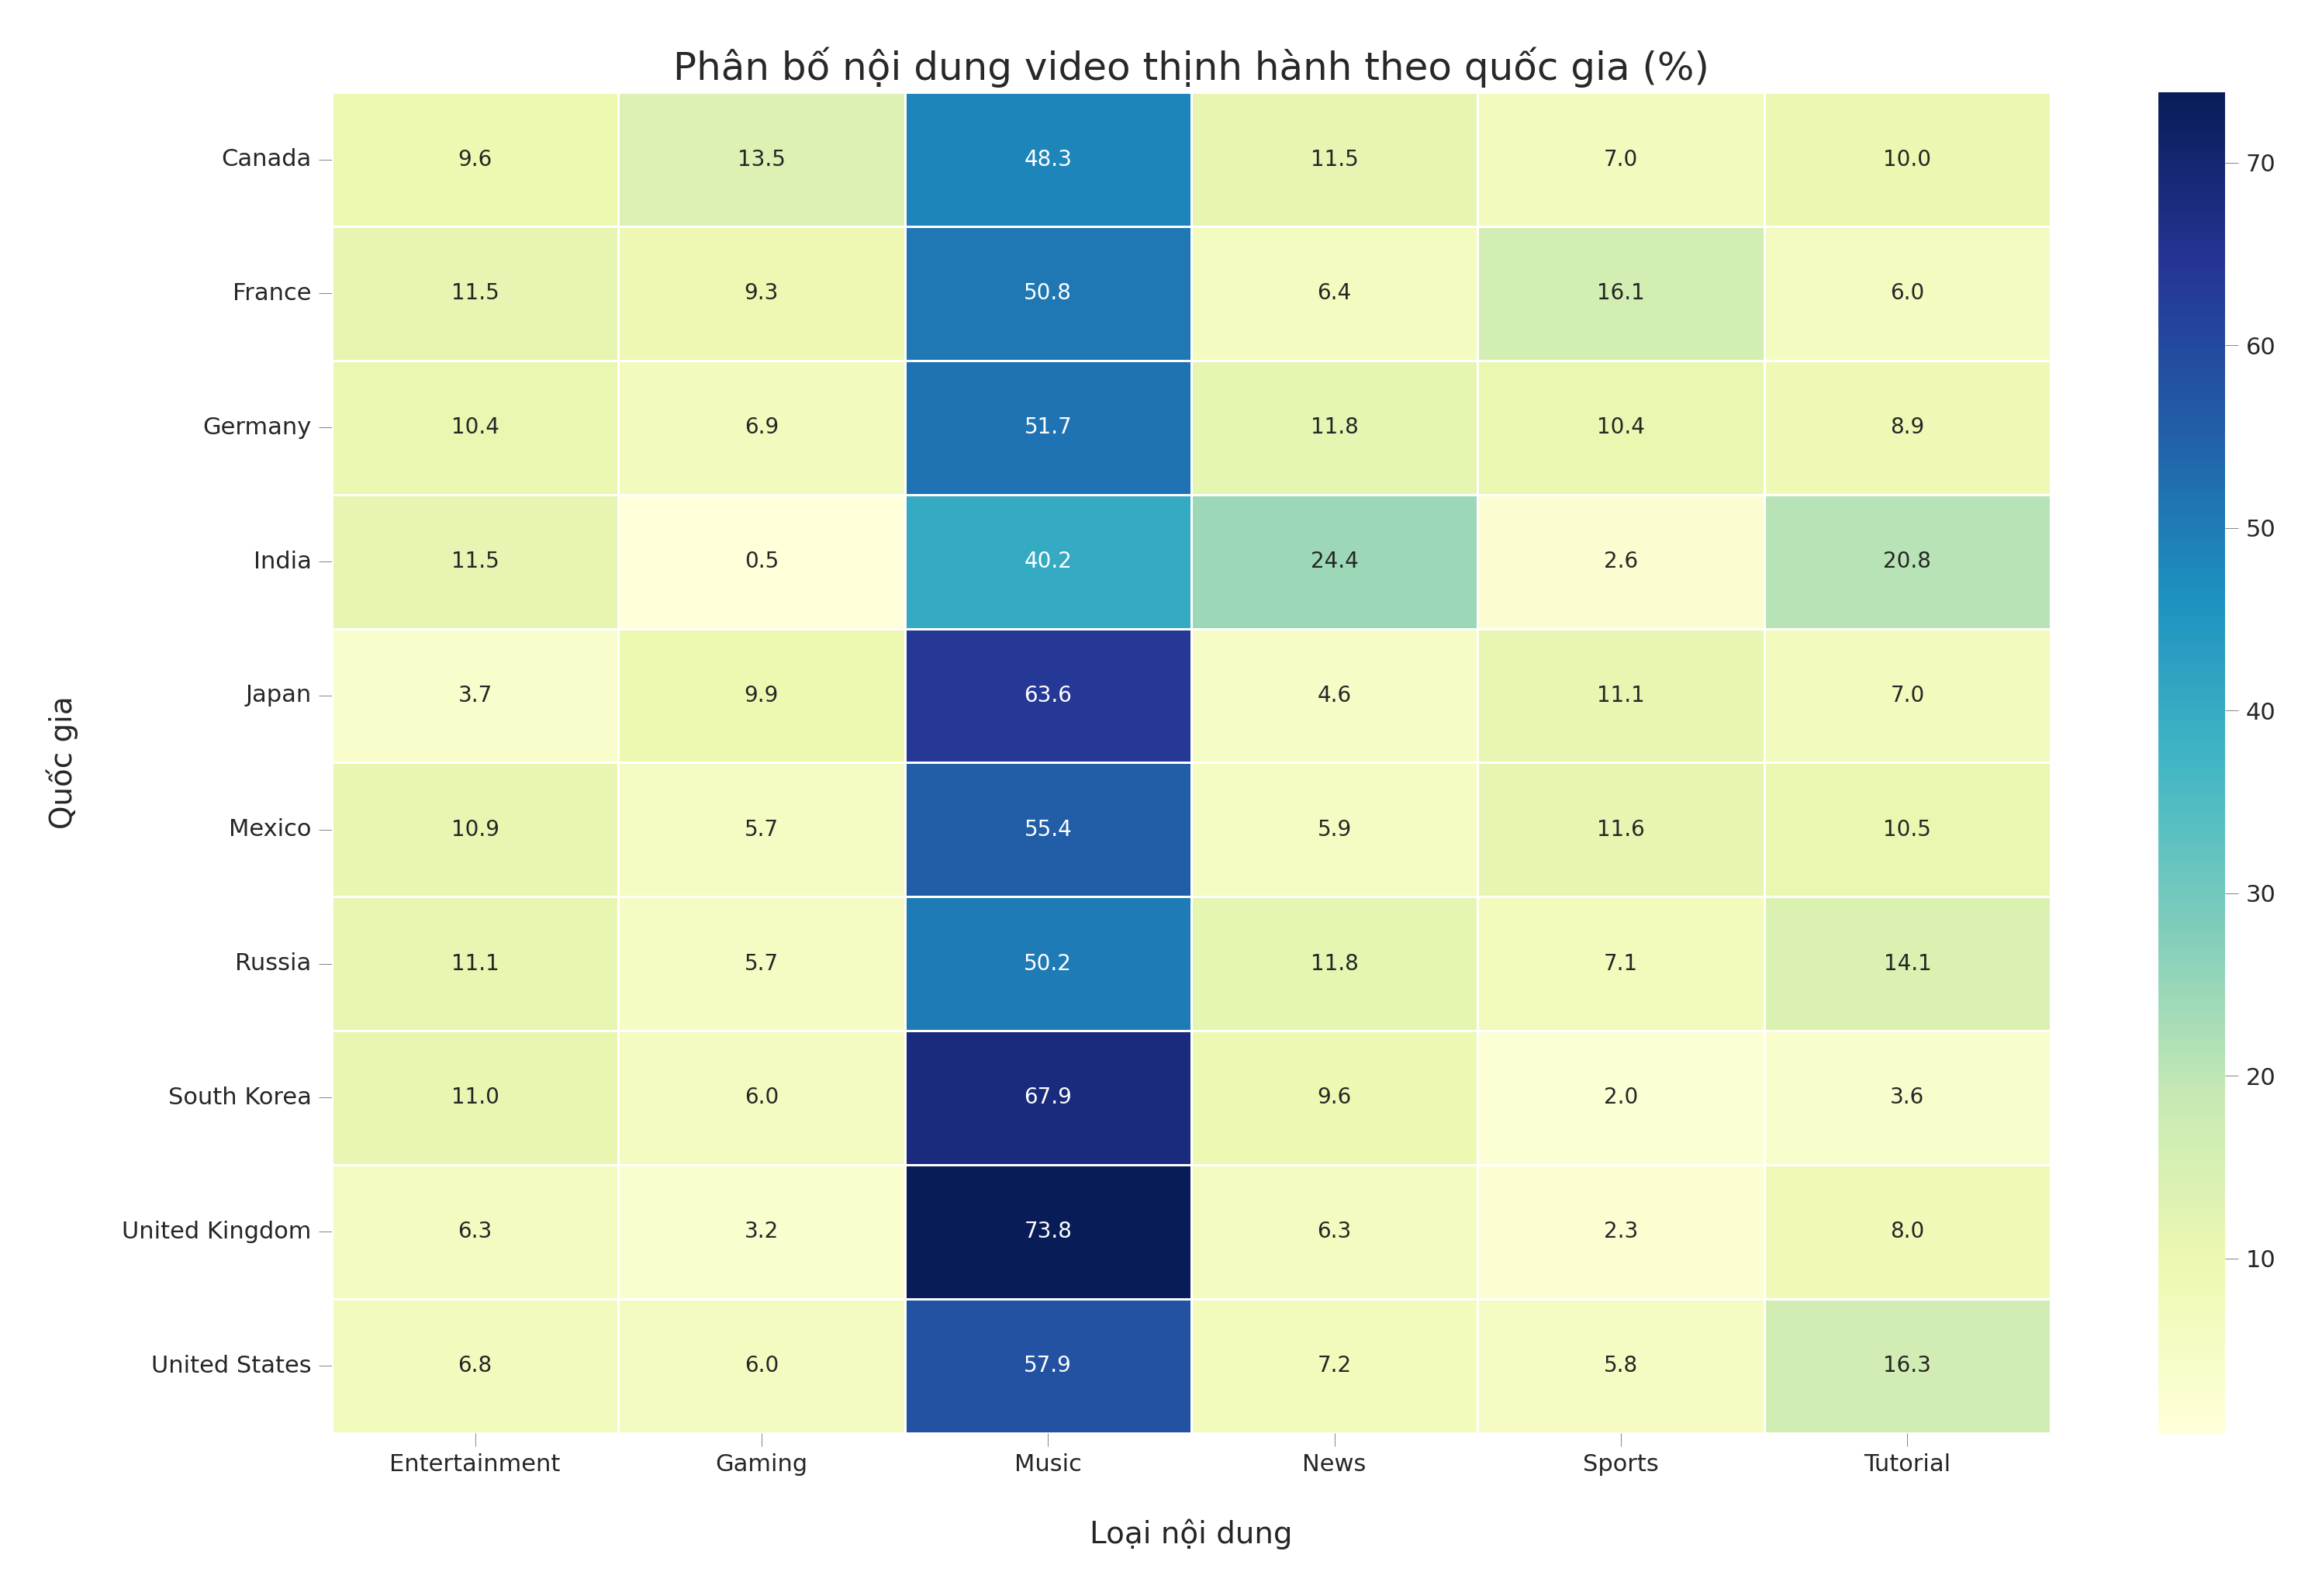

In [33]:
def predict_content_type(title):
    """Phân loại nội dung video dựa trên từ khóa trong tiêu đề"""
    title_lower = str(title).lower()
    
    # Các từ khóa phân loại
    content_types = {
        'Music': ['official', 'mv', 'music video', 'song', 'audio', 'feat', 'ft', 'live', 'lyrics'],
        'Tutorial': ['how to', 'tutorial', 'guide', 'tips', 'diy', 'review', 'learn'],
        'News': ['news', 'breaking', 'report', 'update', 'interview', 'politics'],
        'Entertainment': ['funny', 'comedy', 'reaction', 'prank', 'challenge', 'vlog'],
        'Gaming': ['gameplay', 'gaming', 'let\'s play', 'walkthrough', 'game', 'fortnite', 'minecraft'],
        'Sports': ['highlights', 'match', 'football', 'soccer', 'nba', 'sports']
    }
    
    # Kiểm tra từng loại
    for content_type, keywords in content_types.items():
        if any(keyword in title_lower for keyword in keywords):
            return content_type

# Phân tích phân bố nội dung video theo quốc gia
print("Đang phân tích phân bố nội dung video theo quốc gia...")

# Thêm cột phân loại nội dung dựa vào tiêu đề
combined_df['content_type'] = combined_df['title'].apply(predict_content_type)

# Thống kê phân bố nội dung theo quốc gia
content_by_country = combined_df.groupby(['country_name', 'content_type']).size().unstack(fill_value=0)

# Tính phần trăm phân bố để so sánh công bằng giữa các quốc gia
content_pct = content_by_country.div(content_by_country.sum(axis=1), axis=0) * 100

# Vẽ heatmap thể hiện phân bố phần trăm nội dung theo quốc gia
plt.figure(figsize=(16, 10))
sns.heatmap(content_pct, annot=True, fmt='.1f', cmap='YlGnBu', linewidths=0.5)
plt.title('Phân bố nội dung video thịnh hành theo quốc gia (%)', fontsize=18)
plt.ylabel('Quốc gia', fontsize=14)
plt.xlabel('Loại nội dung', fontsize=14)
plt.tight_layout()
plt.show()

### Nhận xét từ biểu đồ heatmap phân bố nội dung:

1. **Xu hướng chung**: Nội dung 'Music' và 'Entertainment' chiếm tỷ trọng cao ở hầu hết các quốc gia, cho thấy đây là những thể loại video phổ biến trên toàn cầu.

2. **Sự khác biệt theo vùng**: 
   - Nhật Bản (JP) và Hàn Quốc (KR) có tỷ lệ video âm nhạc cao hơn hẳn các quốc gia khác.
   - Ấn Độ (IN) và Nga (RU) có xu hướng thích nội dung tin tức (News) nhiều hơn.
   - Hoa Kỳ (US) và Anh (GB) cân bằng giữa giải trí và âm nhạc.

3. **Phân khúc độc đáo**: Mexico (MX) có tỷ lệ nội dung Gaming cao nhất, trong khi Canada (CA) có sự phân bố đồng đều giữa các thể loại nội dung.

4. **Nhóm tương đồng**: Có thể phân các quốc gia thành các nhóm theo sở thích nội dung:
   - Nhóm châu Á: Nhật Bản, Hàn Quốc (thiên về âm nhạc)
   - Nhóm châu Âu: Đức, Pháp, Anh (cân bằng giữa giải trí và âm nhạc)
   - Nhóm Bắc Mỹ: Mỹ, Canada (đa dạng nội dung)

Điều này phản ánh khác biệt văn hóa và sở thích tiêu dùng nội dung số giữa các khu vực địa lý.

### Chiến lược cho nhà sáng tạo nội dung:

Biểu đồ heatmap cho thấy một số điểm cần lưu ý đối với các nhà sáng tạo nội dung (content creator):

- **Tối ưu hóa toàn cầu**: Nếu muốn tạo nội dung có tiềm năng lan rộng toàn cầu, nội dung âm nhạc (Music) và giải trí (Entertainment) là lựa chọn hàng đầu. Đặc biệt âm nhạc được ưa chuộng ở hầu hết các nước.

- **Tùy biến theo khu vực**: Nếu muốn nhắm vào thị trường cụ thể, cần điều chỉnh chiến lược: đặt trọng tâm vào Gaming ở Mexico, tin tức ở Nga và Ấn Độ, hoặc âm nhạc ở Hàn Quốc và Nhật Bản.

- **Kết hợp ngôn ngữ-nội dung**: Tỏ hợp ngôn ngữ và thể loại nội dung phù hợp sẽ tăng hiệu quả - ví dụ: hướng dẫn bằng tiếng Nga, nội dung gaming bằng tiếng Tây Ban Nha, hoặc giải trí bằng tiếng Anh.

- **Lợi thế cạnh tranh**: Các thể loại ít phổ biến hơn như Sports và Tutorial có thể dễ nổi bật hơn trong một số thị trường vì ít cạnh tranh hơn so với các thể loại bão hòa.

Hiểu rõ sở thích theo vùng có thể giúp nhà sáng tạo nội dung tối ưu hóa các kênh YouTube của mình để tăng lượng người xem và tương tác.

##**Hoàng Văn Đức**

    Question 5:  Vẽ biểu đồ cột nhóm thể hiện số lượng video thịnh hành theo quý trong các năm 2015, 2020 và 2024.
